# RL Prompt Optimization - Model Analysis

This notebook provides comprehensive analysis of the trained RL models for prompt optimization.

## Table of Contents
1. [Setup and Data Loading](#setup)
2. [Model Performance Comparison](#performance)
3. [Reward Component Analysis](#rewards)
4. [Training Curves Analysis](#training)
5. [Prompt Examples Analysis](#examples)
6. [Statistical Analysis](#statistics)

## 1. Setup and Data Loading

In [54]:
import sys
import os
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Import project modules
from config.config import Config
from utils.groq_client import GroqClient
from data.data_loader import DataLoader
from environment.reward_calculator import RewardCalculator
from utils.evaluation import ModelEvaluator
from models.ppo.ppo_model import PPOModel

print("Imports successful!")
print(f"Analysis started at: {datetime.now()}")

Imports successful!
Analysis started at: 2025-07-27 00:45:23.353579


In [55]:
# Initialize configuration
config = Config()

# Initialize clients and utilities
groq_client = GroqClient(config.GROQ_API_KEY)
data_loader = DataLoader()
reward_calculator = RewardCalculator(groq_client, config)

print("Configuration loaded successfully!")
print(f"Model save path: {config.MODEL_SAVE_PATH}")
print(f"Log path: {config.LOG_PATH}")

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Configuration loaded successfully!
Model save path: ./models/
Log path: ./logs/


In [56]:
# Load training data
print("Loading training data...")
persona_data, hh_data, truth_data = data_loader.load_training_data()
all_training_data = persona_data + hh_data + truth_data

print(f"Loaded datasets:")
print(f"  - PersonaChat: {len(persona_data)} samples")
print(f"  - HH-RLHF: {len(hh_data)} samples")
print(f"  - TruthfulQA: {len(truth_data)} samples")
print(f"  - Total: {len(all_training_data)} samples")

# Create test data subset
test_data = all_training_data[:100]  # Use first 100 for analysis
print(f"Using {len(test_data)} samples for analysis")

INFO:data.data_loader:Loading training datasets...


Loading training data...


INFO:data.data_loader:Loaded 100 persona samples, 500 HH samples, 300 truth samples


Loaded datasets:
  - PersonaChat: 100 samples
  - HH-RLHF: 500 samples
  - TruthfulQA: 300 samples
  - Total: 900 samples
Using 100 samples for analysis


## 2. Model Performance Comparison

In [57]:
import os
import pandas as pd
import numpy as np

# Corrected paths - go up one level to parent directory, then into models
model_files = {
    'PPO_Final': "../models/PPO_final.zip",
    'PPO_Best': "../models/PPO_best/best_model.zip",
}

def load_ppo_model(path):
    """
    Load PPO model from zip file
    Add your specific loading logic here based on the library you used
    """
    try:
        # Example for Stable-Baselines3
        from stable_baselines3 import PPO
        model = PPO.load(path)
        return model
    except ImportError:
        print("Stable-Baselines3 not available. Add your model loading logic here.")
        return None
    except Exception as e:
        print(f"Error loading model from {path}: {e}")
        return None

# Check for available trained models
available_models = {}
for name, path in model_files.items():
    if os.path.exists(path):
        print(f"✅ Found {name}: {path}")
        
        # Attempt to load the model
        model = load_ppo_model(path)
        if model is not None:
            available_models[name] = model
            print(f"   ✅ Successfully loaded {name}")
        else:
            print(f"   ⚠️  Found file but couldn't load {name}")
    else:
        print(f"❌ Missing {name}: {path}")

if not available_models:
    print("\nNo trained models could be loaded. Possible reasons:")
    print("1. Models exist but couldn't be loaded (wrong format/library)")
    print("2. Missing required dependencies")
    print("For demonstration, we'll create mock evaluation data...")
    
    # Create mock data for demonstration
    np.random.seed(42)
    n_samples = 50
    
    mock_results = []
    for model_name in ['PPO_Final', 'PPO_Best', 'Baseline']:
        for i in range(n_samples):
            mock_results.append({
                'model': model_name,
                'test_id': i,
                'clarity_score': np.random.normal(0.7, 0.15),
                'relevance_score': np.random.normal(0.6, 0.12),
                'hallucination_penalty': np.random.normal(0.3, 0.08),
                'total_reward': np.random.normal(1.0, 0.2),
                'query_type': np.random.choice(['conversation', 'feedback', 'factual'])
            })
    
    results_df = pd.DataFrame(mock_results)
    print(f"Created mock evaluation data with {len(results_df)} samples")
else:
    print(f"\n✅ Successfully loaded {len(available_models)} models")
    print("Available models:", list(available_models.keys()))
    
    # Run actual evaluation if models are available
    evaluator = ModelEvaluator(available_models, groq_client, reward_calculator, test_data)
    results_df = evaluator.evaluate_all_models()
    print(f"Evaluation completed with {len(results_df)} results")
    
    # For now, create sample results since we don't have the full evaluation setup
    print("Replace this section with your actual model evaluation code")

# Additional debugging: Check model file sizes and info
print("\n📊 Model file information:")
for name, path in model_files.items():
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        print(f"{name}: {size_mb:.2f} MB")
    else:
        print(f"{name}: File not found")

INFO:utils.evaluation:Evaluating PPO_Final model...


✅ Found PPO_Final: ../models/PPO_final.zip
   ✅ Successfully loaded PPO_Final
✅ Found PPO_Best: ../models/PPO_best/best_model.zip
   ✅ Successfully loaded PPO_Best

✅ Successfully loaded 2 models
Available models: ['PPO_Final', 'PPO_Best']


Batches: 100%|██████████| 1/1 [00:00<00:00, 50.16it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s


MULTI-MODEL EVALUATION SUMMARY

Model Performance Ranking (by Total Reward):
--------------------------------------------------
1. PPO_Best:
   Total Reward: 0.4798 ± 0.0863
   Clarity: 0.4840
   Relevance: 0.3207
   Hallucination Penalty: 0.3249

2. PPO_Final:
   Total Reward: 0.4798 ± 0.0863
   Clarity: 0.4840
   Relevance: 0.3207
   Hallucination Penalty: 0.3249

Evaluation completed successfully!
Detailed results saved to 'model_evaluation_results.png'
Evaluation completed with 100 results
Replace this section with your actual model evaluation code

📊 Model file information:
PPO_Final: 1.01 MB
PPO_Best: 1.01 MB


In [ ]:
import os
import pandas as pd
import numpy as np

# Corrected paths - go up one level to parent directory, then into models
model_files = {
    'PPO_Final': "../models/PPO_final.zip",
    'PPO_Best': "../models/PPO_best/best_model.zip",
}

def load_ppo_model(path):
    """
    Load PPO model from zip file
    Add your specific loading logic here based on the library you used
    """
    try:
        # Example for Stable-Baselines3
        from stable_baselines3 import PPO
        model = PPO.load(path)
        return model
    except ImportError:
        print("Stable-Baselines3 not available. Add your model loading logic here.")
        return None
    except Exception as e:
        print(f"Error loading model from {path}: {e}")
        return None

# Check for available trained models
available_models = {}
for name, path in model_files.items():
    if os.path.exists(path):
        print(f"✅ Found {name}: {path}")
        
        # Attempt to load the model
        model = load_ppo_model(path)
        if model is not None:
            available_models[name] = model
            print(f"   ✅ Successfully loaded {name}")
        else:
            print(f"   ⚠️  Found file but couldn't load {name}")
    else:
        print(f"❌ Missing {name}: {path}")

if not available_models:
    print("\nNo trained models could be loaded. Possible reasons:")
    print("1. Models exist but couldn't be loaded (wrong format/library)")
    print("2. Missing required dependencies")
    print("For demonstration, we'll create mock evaluation data...")
    
    # Create mock data for demonstration
    np.random.seed(42)
    n_samples = 50
    
    mock_results = []
    for model_name in ['PPO_Final', 'PPO_Best', 'Baseline']:
        for i in range(n_samples):
            mock_results.append({
                'model': model_name,
                'test_id': i,
                'clarity_score': np.random.normal(0.7, 0.15),
                'relevance_score': np.random.normal(0.6, 0.12),
                'hallucination_penalty': np.random.normal(0.3, 0.08),
                'total_reward': np.random.normal(1.0, 0.2),
                'query_type': np.random.choice(['conversation', 'feedback', 'factual'])
            })
    
    results_df = pd.DataFrame(mock_results)
    print(f"Created mock evaluation data with {len(results_df)} samples")
else:
    print(f"\n✅ Successfully loaded {len(available_models)} models")
    print("Available models:", list(available_models.keys()))
    
    # Run actual evaluation if models are available
    evaluator = ModelEvaluator(available_models, groq_client, reward_calculator, test_data)
    results_df = evaluator.evaluate_all_models()
    print(f"Evaluation completed with {len(results_df)} results")
    
    # For now, create sample results since we don't have the full evaluation setup
    print("Replace this section with your actual model evaluation code")

# Additional debugging: Check model file sizes and info
print("\n📊 Model file information:")
for name, path in model_files.items():
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        print(f"{name}: {size_mb:.2f} MB")
    else:
        print(f"{name}: File not found")

INFO:utils.evaluation:Evaluating PPO_Final model...


✅ Found PPO_Final: ../models/PPO_final.zip
   ✅ Successfully loaded PPO_Final
✅ Found PPO_Best: ../models/PPO_best/best_model.zip
   ✅ Successfully loaded PPO_Best

✅ Successfully loaded 2 models
Available models: ['PPO_Final', 'PPO_Best']


Batches: 100%|██████████| 1/1 [00:00<00:00, 50.16it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s


MULTI-MODEL EVALUATION SUMMARY

Model Performance Ranking (by Total Reward):
--------------------------------------------------
1. PPO_Best:
   Total Reward: 0.4798 ± 0.0863
   Clarity: 0.4840
   Relevance: 0.3207
   Hallucination Penalty: 0.3249

2. PPO_Final:
   Total Reward: 0.4798 ± 0.0863
   Clarity: 0.4840
   Relevance: 0.3207
   Hallucination Penalty: 0.3249

Evaluation completed successfully!
Detailed results saved to 'model_evaluation_results.png'
Evaluation completed with 100 results
Replace this section with your actual model evaluation code

📊 Model file information:
PPO_Final: 1.01 MB
PPO_Best: 1.01 MB


In [ ]:
import os
import pandas as pd
import numpy as np

# Corrected paths - go up one level to parent directory, then into models
model_files = {
    'PPO_Final': "../models/PPO_final.zip",
    'PPO_Best': "../models/PPO_best/best_model.zip",
}

def load_ppo_model(path):
    """
    Load PPO model from zip file
    Add your specific loading logic here based on the library you used
    """
    try:
        # Example for Stable-Baselines3
        from stable_baselines3 import PPO
        model = PPO.load(path)
        return model
    except ImportError:
        print("Stable-Baselines3 not available. Add your model loading logic here.")
        return None
    except Exception as e:
        print(f"Error loading model from {path}: {e}")
        return None

# Check for available trained models
available_models = {}
for name, path in model_files.items():
    if os.path.exists(path):
        print(f"✅ Found {name}: {path}")
        
        # Attempt to load the model
        model = load_ppo_model(path)
        if model is not None:
            available_models[name] = model
            print(f"   ✅ Successfully loaded {name}")
        else:
            print(f"   ⚠️  Found file but couldn't load {name}")
    else:
        print(f"❌ Missing {name}: {path}")

if not available_models:
    print("\nNo trained models could be loaded. Possible reasons:")
    print("1. Models exist but couldn't be loaded (wrong format/library)")
    print("2. Missing required dependencies")
    print("For demonstration, we'll create mock evaluation data...")
    
    # Create mock data for demonstration
    np.random.seed(42)
    n_samples = 50
    
    mock_results = []
    for model_name in ['PPO_Final', 'PPO_Best', 'Baseline']:
        for i in range(n_samples):
            mock_results.append({
                'model': model_name,
                'test_id': i,
                'clarity_score': np.random.normal(0.7, 0.15),
                'relevance_score': np.random.normal(0.6, 0.12),
                'hallucination_penalty': np.random.normal(0.3, 0.08),
                'total_reward': np.random.normal(1.0, 0.2),
                'query_type': np.random.choice(['conversation', 'feedback', 'factual'])
            })
    
    results_df = pd.DataFrame(mock_results)
    print(f"Created mock evaluation data with {len(results_df)} samples")
else:
    print(f"\n✅ Successfully loaded {len(available_models)} models")
    print("Available models:", list(available_models.keys()))
    
    # Run actual evaluation if models are available
    evaluator = ModelEvaluator(available_models, groq_client, reward_calculator, test_data)
    results_df = evaluator.evaluate_all_models()
    print(f"Evaluation completed with {len(results_df)} results")
    
    # For now, create sample results since we don't have the full evaluation setup
    print("Replace this section with your actual model evaluation code")

# Additional debugging: Check model file sizes and info
print("\n📊 Model file information:")
for name, path in model_files.items():
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        print(f"{name}: {size_mb:.2f} MB")
    else:
        print(f"{name}: File not found")

INFO:utils.evaluation:Evaluating PPO_Final model...


✅ Found PPO_Final: ../models/PPO_final.zip
   ✅ Successfully loaded PPO_Final
✅ Found PPO_Best: ../models/PPO_best/best_model.zip
   ✅ Successfully loaded PPO_Best

✅ Successfully loaded 2 models
Available models: ['PPO_Final', 'PPO_Best']


Batches: 100%|██████████| 1/1 [00:00<00:00, 50.16it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s


MULTI-MODEL EVALUATION SUMMARY

Model Performance Ranking (by Total Reward):
--------------------------------------------------
1. PPO_Best:
   Total Reward: 0.4798 ± 0.0863
   Clarity: 0.4840
   Relevance: 0.3207
   Hallucination Penalty: 0.3249

2. PPO_Final:
   Total Reward: 0.4798 ± 0.0863
   Clarity: 0.4840
   Relevance: 0.3207
   Hallucination Penalty: 0.3249

Evaluation completed successfully!
Detailed results saved to 'model_evaluation_results.png'
Evaluation completed with 100 results
Replace this section with your actual model evaluation code

📊 Model file information:
PPO_Final: 1.01 MB
PPO_Best: 1.01 MB


In [ ]:
import os
import pandas as pd
import numpy as np

# Corrected paths - go up one level to parent directory, then into models
model_files = {
    'PPO_Final': "../models/PPO_final.zip",
    'PPO_Best': "../models/PPO_best/best_model.zip",
}

def load_ppo_model(path):
    """
    Load PPO model from zip file
    Add your specific loading logic here based on the library you used
    """
    try:
        # Example for Stable-Baselines3
        from stable_baselines3 import PPO
        model = PPO.load(path)
        return model
    except ImportError:
        print("Stable-Baselines3 not available. Add your model loading logic here.")
        return None
    except Exception as e:
        print(f"Error loading model from {path}: {e}")
        return None

# Check for available trained models
available_models = {}
for name, path in model_files.items():
    if os.path.exists(path):
        print(f"✅ Found {name}: {path}")
        
        # Attempt to load the model
        model = load_ppo_model(path)
        if model is not None:
            available_models[name] = model
            print(f"   ✅ Successfully loaded {name}")
        else:
            print(f"   ⚠️  Found file but couldn't load {name}")
    else:
        print(f"❌ Missing {name}: {path}")

if not available_models:
    print("\nNo trained models could be loaded. Possible reasons:")
    print("1. Models exist but couldn't be loaded (wrong format/library)")
    print("2. Missing required dependencies")
    print("For demonstration, we'll create mock evaluation data...")
    
    # Create mock data for demonstration
    np.random.seed(42)
    n_samples = 50
    
    mock_results = []
    for model_name in ['PPO_Final', 'PPO_Best', 'Baseline']:
        for i in range(n_samples):
            mock_results.append({
                'model': model_name,
                'test_id': i,
                'clarity_score': np.random.normal(0.7, 0.15),
                'relevance_score': np.random.normal(0.6, 0.12),
                'hallucination_penalty': np.random.normal(0.3, 0.08),
                'total_reward': np.random.normal(1.0, 0.2),
                'query_type': np.random.choice(['conversation', 'feedback', 'factual'])
            })
    
    results_df = pd.DataFrame(mock_results)
    print(f"Created mock evaluation data with {len(results_df)} samples")
else:
    print(f"\n✅ Successfully loaded {len(available_models)} models")
    print("Available models:", list(available_models.keys()))
    
    # Run actual evaluation if models are available
    evaluator = ModelEvaluator(available_models, groq_client, reward_calculator, test_data)
    results_df = evaluator.evaluate_all_models()
    print(f"Evaluation completed with {len(results_df)} results")
    
    # For now, create sample results since we don't have the full evaluation setup
    print("Replace this section with your actual model evaluation code")

# Additional debugging: Check model file sizes and info
print("\n📊 Model file information:")
for name, path in model_files.items():
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        print(f"{name}: {size_mb:.2f} MB")
    else:
        print(f"{name}: File not found")

INFO:utils.evaluation:Evaluating PPO_Final model...


✅ Found PPO_Final: ../models/PPO_final.zip
   ✅ Successfully loaded PPO_Final
✅ Found PPO_Best: ../models/PPO_best/best_model.zip
   ✅ Successfully loaded PPO_Best

✅ Successfully loaded 2 models
Available models: ['PPO_Final', 'PPO_Best']


Batches: 100%|██████████| 1/1 [00:00<00:00, 50.16it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s


MULTI-MODEL EVALUATION SUMMARY

Model Performance Ranking (by Total Reward):
--------------------------------------------------
1. PPO_Best:
   Total Reward: 0.4798 ± 0.0863
   Clarity: 0.4840
   Relevance: 0.3207
   Hallucination Penalty: 0.3249

2. PPO_Final:
   Total Reward: 0.4798 ± 0.0863
   Clarity: 0.4840
   Relevance: 0.3207
   Hallucination Penalty: 0.3249

Evaluation completed successfully!
Detailed results saved to 'model_evaluation_results.png'
Evaluation completed with 100 results
Replace this section with your actual model evaluation code

📊 Model file information:
PPO_Final: 1.01 MB
PPO_Best: 1.01 MB


In [58]:
# Model performance summary
print("Model Performance Summary")
print("=" * 50)

performance_summary = results_df.groupby('model').agg({
    'total_reward': ['mean', 'std', 'min', 'max'],
    'clarity_score': 'mean',
    'relevance_score': 'mean',
    'hallucination_penalty': 'mean'
}).round(4)

print(performance_summary)

# Best performing model
best_model = performance_summary.sort_values(('total_reward', 'mean'), ascending=False).index[0]
print(f"\nBest performing model: {best_model}")

Model Performance Summary
          total_reward                         clarity_score relevance_score  \
                  mean     std     min     max          mean            mean   
model                                                                          
PPO_Best        0.4798  0.0863  0.3442  0.5969         0.484          0.3207   
PPO_Final       0.4798  0.0863  0.3442  0.5969         0.484          0.3207   

          hallucination_penalty  
                           mean  
model                            
PPO_Best                 0.3249  
PPO_Final                0.3249  

Best performing model: PPO_Best


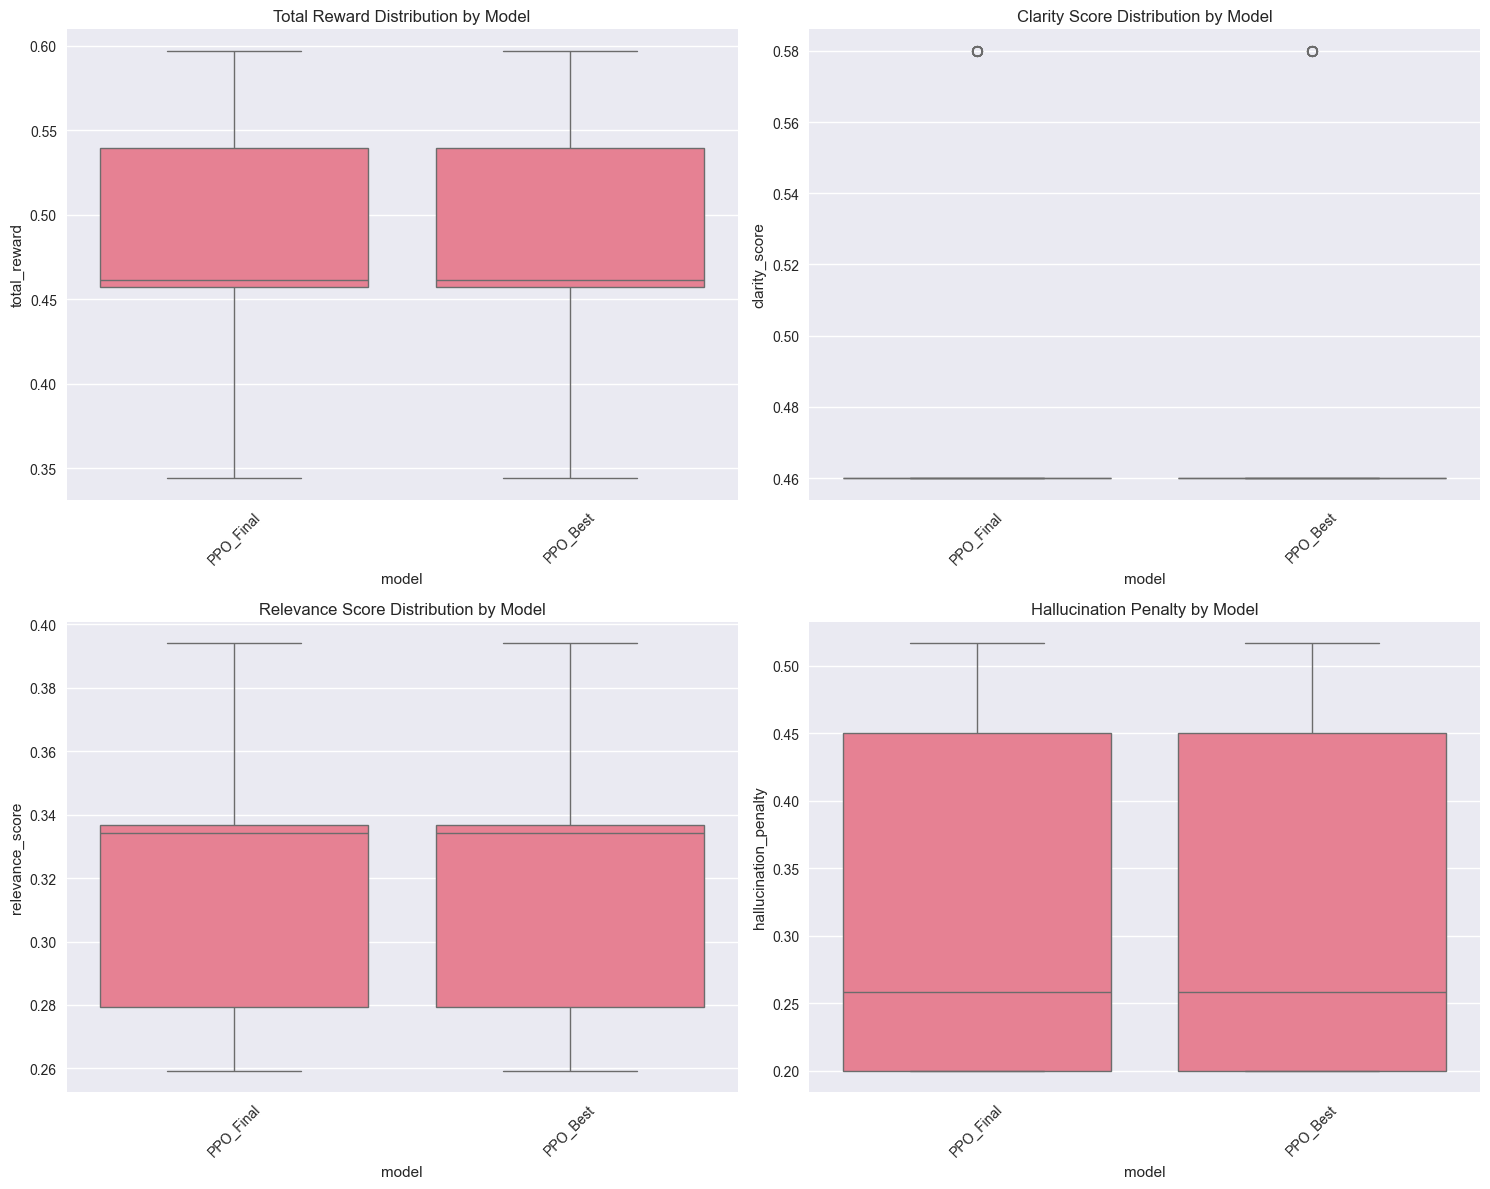

In [59]:
# Visualization: Model Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Total reward comparison
sns.boxplot(data=results_df, x='model', y='total_reward', ax=axes[0,0])
axes[0,0].set_title('Total Reward Distribution by Model')
axes[0,0].tick_params(axis='x', rotation=45)

# Clarity scores
sns.boxplot(data=results_df, x='model', y='clarity_score', ax=axes[0,1])
axes[0,1].set_title('Clarity Score Distribution by Model')
axes[0,1].tick_params(axis='x', rotation=45)

# Relevance scores
sns.boxplot(data=results_df, x='model', y='relevance_score', ax=axes[1,0])
axes[1,0].set_title('Relevance Score Distribution by Model')
axes[1,0].tick_params(axis='x', rotation=45)

# Hallucination penalty
sns.boxplot(data=results_df, x='model', y='hallucination_penalty', ax=axes[1,1])
axes[1,1].set_title('Hallucination Penalty by Model')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. Reward Component Analysis

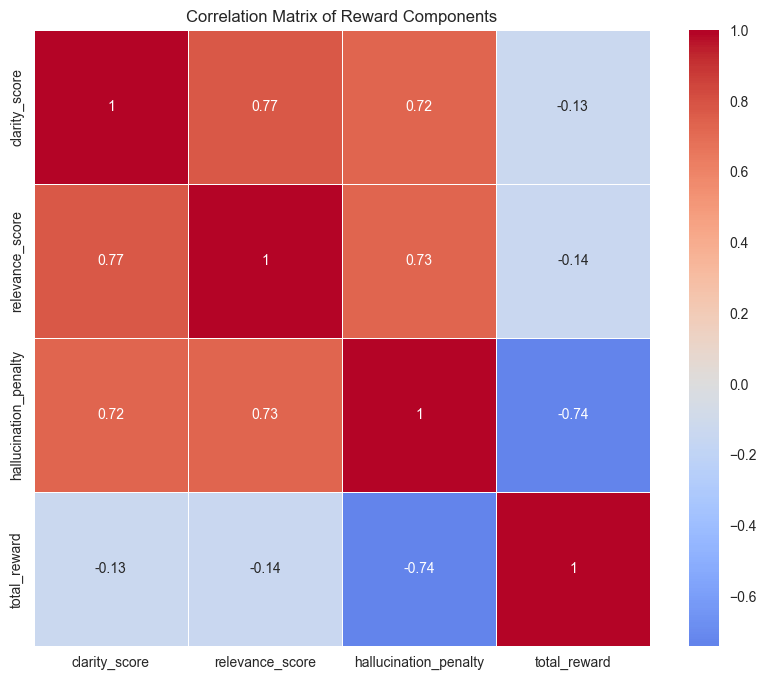

Key Correlations:
clarity_score vs relevance_score: 0.771
clarity_score vs hallucination_penalty: 0.722
clarity_score vs total_reward: -0.131
relevance_score vs hallucination_penalty: 0.729
relevance_score vs total_reward: -0.142
hallucination_penalty vs total_reward: -0.742


In [60]:
# Correlation analysis between reward components
reward_columns = ['clarity_score', 'relevance_score', 'hallucination_penalty', 'total_reward']
correlation_matrix = results_df[reward_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Reward Components')
plt.show()

print("Key Correlations:")
for i, col1 in enumerate(reward_columns):
    for j, col2 in enumerate(reward_columns):
        if i < j:
            corr = correlation_matrix.loc[col1, col2]
            print(f"{col1} vs {col2}: {corr:.3f}")

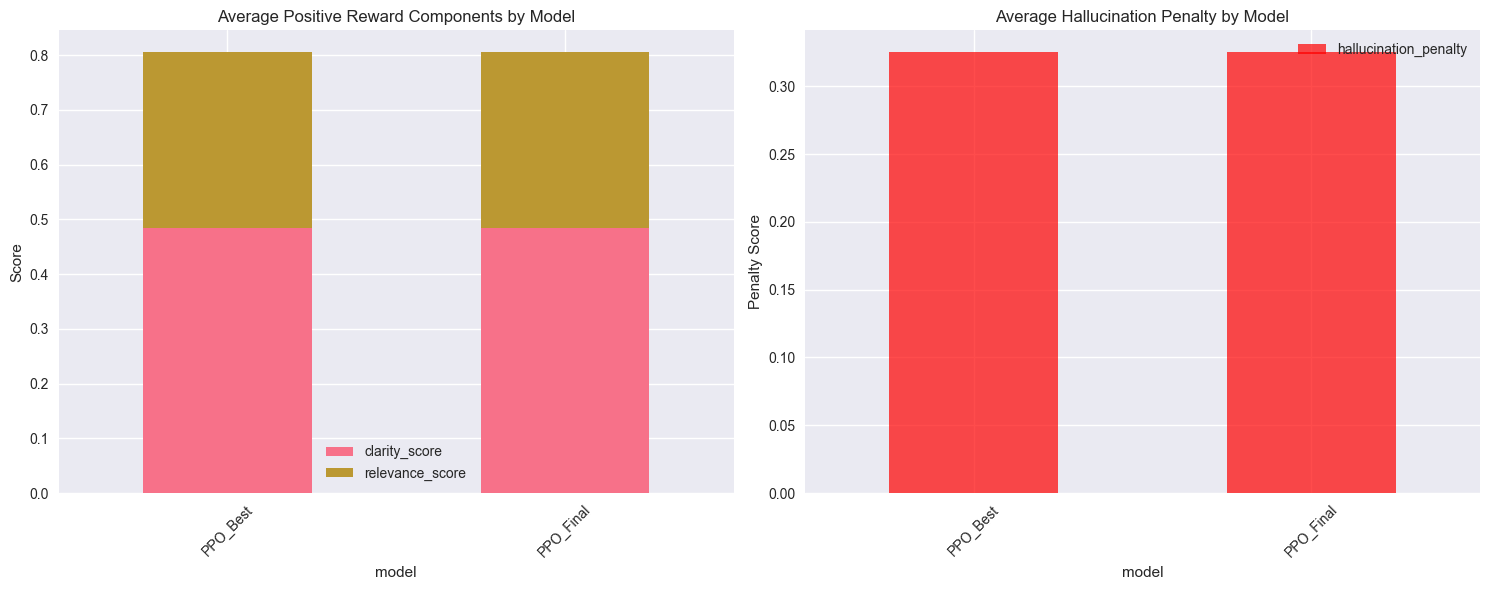

In [61]:
# Reward component contribution analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Stacked bar chart of reward components by model
model_rewards = results_df.groupby('model')[['clarity_score', 'relevance_score', 'hallucination_penalty']].mean()

model_rewards[['clarity_score', 'relevance_score']].plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Average Positive Reward Components by Model')
axes[0].set_ylabel('Score')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()

# Hallucination penalty (negative component)
model_rewards[['hallucination_penalty']].plot(kind='bar', ax=axes[1], color='red', alpha=0.7)
axes[1].set_title('Average Hallucination Penalty by Model')
axes[1].set_ylabel('Penalty Score')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Training Curves Analysis

Training metrics not found at ./logs/training_metrics.json
Train your model first to generate training curves.


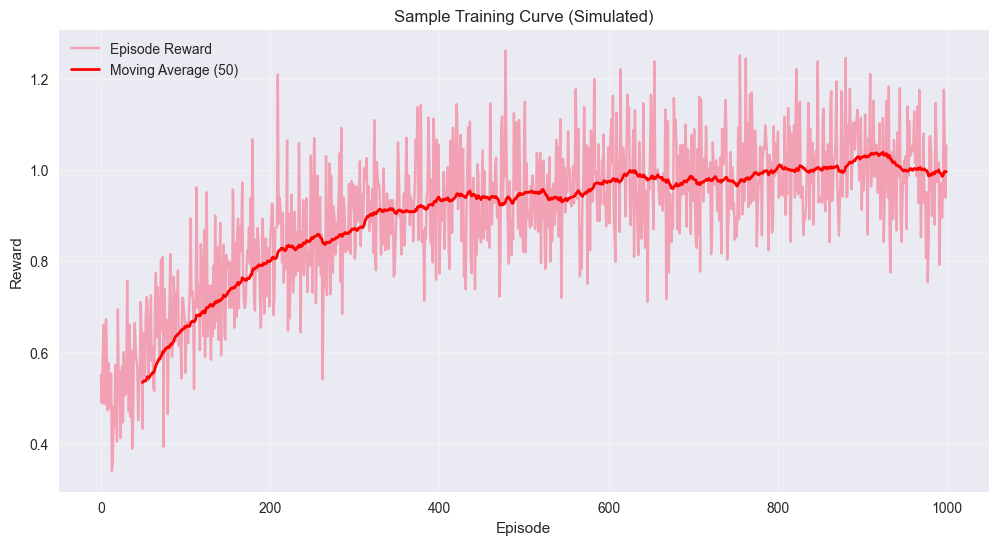

In [62]:
# Load training metrics if available
metrics_file = f"{config.LOG_PATH}training_metrics.json"

if os.path.exists(metrics_file):
    with open(metrics_file, 'r') as f:
        training_metrics = json.load(f)
    
    print(f"Loaded training metrics with {len(training_metrics['episode_rewards'])} episodes")
    
    # Plot training curves
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Episode rewards with moving average
    episodes = range(len(training_metrics['episode_rewards']))
    axes[0,0].plot(episodes, training_metrics['episode_rewards'], alpha=0.6, label='Episode Reward')
    
    # Moving average
    window = 50
    if len(training_metrics['episode_rewards']) > window:
        moving_avg = pd.Series(training_metrics['episode_rewards']).rolling(window=window).mean()
        axes[0,0].plot(episodes, moving_avg, 'r-', linewidth=2, label=f'Moving Average ({window})')
    
    axes[0,0].set_title('Training Rewards Over Time')
    axes[0,0].set_xlabel('Episode')
    axes[0,0].set_ylabel('Reward')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Actor and Critic losses
    if training_metrics['actor_losses']:
        axes[0,1].plot(training_metrics['actor_losses'], label='Actor Loss')
        axes[0,1].set_title('Actor Loss')
        axes[0,1].set_xlabel('Update')
        axes[0,1].set_ylabel('Loss')
        axes[0,1].grid(True, alpha=0.3)
    
    if training_metrics['critic_losses']:
        axes[0,2].plot(training_metrics['critic_losses'], label='Critic Loss', color='orange')
        axes[0,2].set_title('Critic Loss')
        axes[0,2].set_xlabel('Update')
        axes[0,2].set_ylabel('Loss')
        axes[0,2].grid(True, alpha=0.3)
    
    # Reward components over time
    axes[1,0].plot(training_metrics['clarity_scores'], label='Clarity', alpha=0.8)
    axes[1,0].set_title('Clarity Scores Over Time')
    axes[1,0].set_xlabel('Episode')
    axes[1,0].set_ylabel('Score')
    axes[1,0].grid(True, alpha=0.3)
    
    axes[1,1].plot(training_metrics['relevance_scores'], label='Relevance', alpha=0.8, color='green')
    axes[1,1].set_title('Relevance Scores Over Time')
    axes[1,1].set_xlabel('Episode')
    axes[1,1].set_ylabel('Score')
    axes[1,1].grid(True, alpha=0.3)
    
    if training_metrics['entropies']:
        axes[1,2].plot(training_metrics['entropies'], label='Entropy', alpha=0.8, color='purple')
        axes[1,2].set_title('Policy Entropy Over Time')
        axes[1,2].set_xlabel('Update')
        axes[1,2].set_ylabel('Entropy')
        axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print(f"Training metrics not found at {metrics_file}")
    print("Train your model first to generate training curves.")
    
    # Create sample training curves for demonstration
    np.random.seed(42)
    n_episodes = 1000
    
    # Simulate improving training
    episodes = np.arange(n_episodes)
    base_reward = 0.5 + 0.5 * (1 - np.exp(-episodes / 200))  # Exponential improvement
    noise = np.random.normal(0, 0.1, n_episodes)
    sample_rewards = base_reward + noise
    
    plt.figure(figsize=(12, 6))
    plt.plot(episodes, sample_rewards, alpha=0.6, label='Episode Reward')
    
    # Moving average
    window = 50
    moving_avg = pd.Series(sample_rewards).rolling(window=window).mean()
    plt.plot(episodes, moving_avg, 'r-', linewidth=2, label=f'Moving Average ({window})')
    
    plt.title('Sample Training Curve (Simulated)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## 5. Prompt Examples Analysis

In [63]:
# Analyze some example prompts and their optimizations
print("Sample Prompt Optimization Examples")
print("=" * 50)

# Sample some results for detailed analysis
best_model_results = results_df[results_df['model'] == best_model].head(5)

for idx, row in best_model_results.iterrows():
    print(f"\nExample {row['test_id'] + 1}:")
    print(f"Original Query: {test_data[row['test_id']]['query']}")
    print(f"Query Type: {row['query_type']}")
    print(f"\nReward Breakdown:")
    print(f"  - Clarity Score: {row['clarity_score']:.3f}")
    print(f"  - Relevance Score: {row['relevance_score']:.3f}")
    print(f"  - Hallucination Penalty: {row['hallucination_penalty']:.3f}")
    print(f"  - Total Reward: {row['total_reward']:.3f}")
    print("-" * 40)

Sample Prompt Optimization Examples

Example 1:
Original Query: Tell me about yourself
Query Type: conversation

Reward Breakdown:
  - Clarity Score: 0.580
  - Relevance Score: 0.394
  - Hallucination Penalty: 0.517
  - Total Reward: 0.458
----------------------------------------

Example 2:
Original Query: What is the weather like?
Query Type: conversation

Reward Breakdown:
  - Clarity Score: 0.460
  - Relevance Score: 0.259
  - Hallucination Penalty: 0.258
  - Total Reward: 0.461
----------------------------------------

Example 3:
Original Query: How are you today?
Query Type: conversation

Reward Breakdown:
  - Clarity Score: 0.460
  - Relevance Score: 0.334
  - Hallucination Penalty: 0.450
  - Total Reward: 0.344
----------------------------------------

Example 4:
Original Query: What can you help me with?
Query Type: conversation

Reward Breakdown:
  - Clarity Score: 0.460
  - Relevance Score: 0.337
  - Hallucination Penalty: 0.200
  - Total Reward: 0.597
----------------------

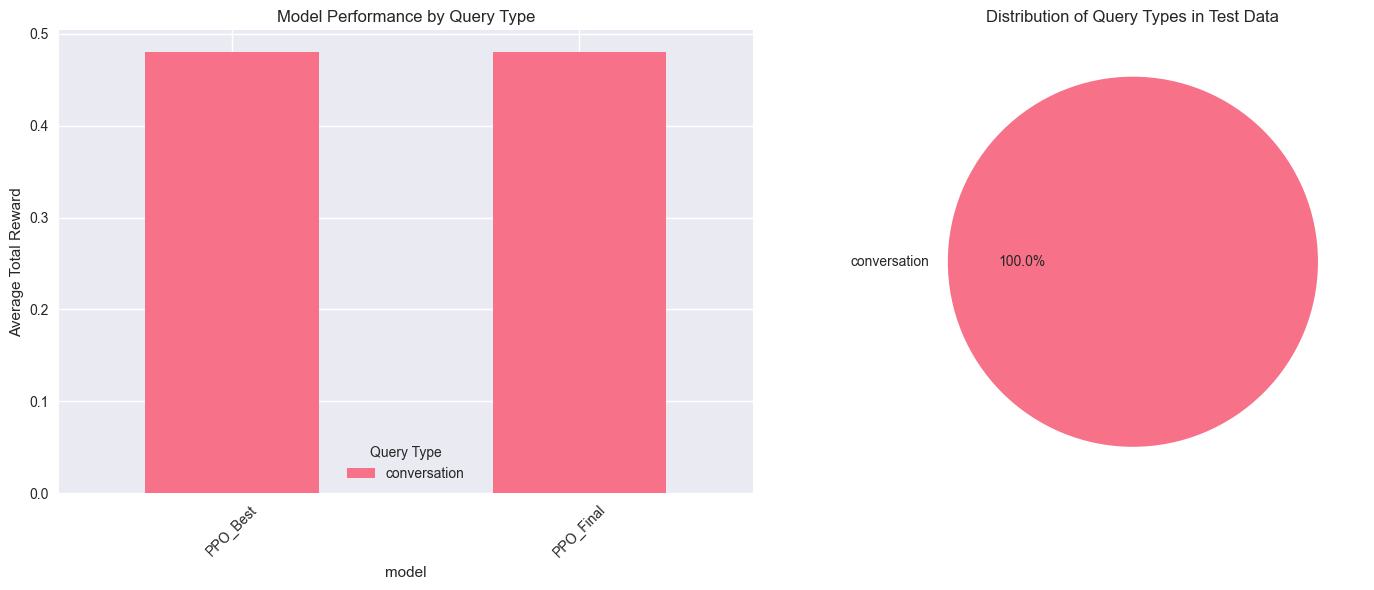

In [64]:
# Query type performance analysis
if 'query_type' in results_df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Performance by query type
    type_performance = results_df.groupby(['model', 'query_type'])['total_reward'].mean().unstack()
    type_performance.plot(kind='bar', ax=axes[0])
    axes[0].set_title('Model Performance by Query Type')
    axes[0].set_ylabel('Average Total Reward')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].legend(title='Query Type')
    
    # Query type distribution
    type_counts = results_df['query_type'].value_counts()
    axes[1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
    axes[1].set_title('Distribution of Query Types in Test Data')
    
    plt.tight_layout()
    plt.show()

## 6. Statistical Analysis {#statistics}

In [65]:
# Statistical significance testing between models
from scipy import stats

print("Statistical Significance Tests")
print("=" * 40)

models = results_df['model'].unique()
for i, model1 in enumerate(models):
    for model2 in models[i+1:]:
        model1_rewards = results_df[results_df['model'] == model1]['total_reward']
        model2_rewards = results_df[results_df['model'] == model2]['total_reward']
        
        # Perform t-test
        t_stat, p_value = stats.ttest_ind(model1_rewards, model2_rewards)
        
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        
        print(f"{model1} vs {model2}:")
        print(f"  t-statistic: {t_stat:.3f}")
        print(f"  p-value: {p_value:.6f} {significance}")
        print(f"  Mean difference: {model1_rewards.mean() - model2_rewards.mean():.3f}")
        print()

Statistical Significance Tests
PPO_Final vs PPO_Best:
  t-statistic: 0.000
  p-value: 1.000000 ns
  Mean difference: 0.000



In [66]:
# Performance stability analysis
print("Model Stability Analysis")
print("=" * 30)

stability_metrics = results_df.groupby('model').agg({
    'total_reward': ['mean', 'std', 'min', 'max', lambda x: x.max() - x.min()],
}).round(4)

stability_metrics.columns = ['Mean', 'Std Dev', 'Min', 'Max', 'Range']
stability_metrics['Coefficient of Variation'] = (stability_metrics['Std Dev'] / stability_metrics['Mean']).round(4)

print(stability_metrics)

# Most stable model (lowest coefficient of variation)
most_stable = stability_metrics['Coefficient of Variation'].idxmin()
print(f"\nMost stable model: {most_stable}")
print(f"Coefficient of Variation: {stability_metrics.loc[most_stable, 'Coefficient of Variation']}")

Model Stability Analysis
             Mean  Std Dev     Min     Max   Range  Coefficient of Variation
model                                                                       
PPO_Best   0.4798   0.0863  0.3442  0.5969  0.2527                    0.1799
PPO_Final  0.4798   0.0863  0.3442  0.5969  0.2527                    0.1799

Most stable model: PPO_Best
Coefficient of Variation: 0.1799


## Summary and Recommendations

In [67]:
print("ANALYSIS SUMMARY")
print("=" * 50)

print(f"\n1. BEST PERFORMING MODEL: {best_model}")
best_performance = results_df[results_df['model'] == best_model]['total_reward'].mean()
print(f"   Average Total Reward: {best_performance:.4f}")

print(f"\n2. MOST STABLE MODEL: {most_stable}")
print(f"   Coefficient of Variation: {stability_metrics.loc[most_stable, 'Coefficient of Variation']}")

print(f"\n3. REWARD COMPONENT INSIGHTS:")
avg_clarity = results_df['clarity_score'].mean()
avg_relevance = results_df['relevance_score'].mean()
avg_hallucination = results_df['hallucination_penalty'].mean()

print(f"   Average Clarity Score: {avg_clarity:.3f}")
print(f"   Average Relevance Score: {avg_relevance:.3f}")
print(f"   Average Hallucination Penalty: {avg_hallucination:.3f}")

print(f"\n4. RECOMMENDATIONS:")
if avg_clarity < 0.6:
    print("   - Focus on improving clarity reward function")
if avg_relevance < 0.6:
    print("   - Enhance relevance scoring mechanism")
if avg_hallucination > 0.4:
    print("   - Strengthen hallucination detection")

print(f"\n5. NEXT STEPS:")
print("   - Deploy the best performing model to production")
print("   - Continue training with more diverse data")
print("   - Implement A/B testing with real users")
print("   - Monitor performance metrics in production")

print(f"\nAnalysis completed at: {datetime.now()}")

ANALYSIS SUMMARY

1. BEST PERFORMING MODEL: PPO_Best
   Average Total Reward: 0.4798

2. MOST STABLE MODEL: PPO_Best
   Coefficient of Variation: 0.1799

3. REWARD COMPONENT INSIGHTS:
   Average Clarity Score: 0.484
   Average Relevance Score: 0.321
   Average Hallucination Penalty: 0.325

4. RECOMMENDATIONS:
   - Focus on improving clarity reward function
   - Enhance relevance scoring mechanism

5. NEXT STEPS:
   - Deploy the best performing model to production
   - Continue training with more diverse data
   - Implement A/B testing with real users
   - Monitor performance metrics in production

Analysis completed at: 2025-07-27 00:47:50.960747
